### Experiments setup

In [1]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from pycox import datasets
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = datasets.metabric.read_df()
feat_cols = ["x0", "x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
feats = df[feat_cols]
surv_label = df[["duration", "event"]].values

In [3]:
numeric_feat_cols = ["x0", "x1", "x2", "x3", "x8"]
cate_feat_cols = [col for col in feat_cols if col not in numeric_feat_cols]

In [4]:
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
feats_new = feats[numeric_feat_cols]
feat_enc_cols = []
enc_dict = {}
for feat_col in cate_feat_cols:
    enc = OneHotEncoder(drop='if_binary')
    feat_new = enc.fit_transform(feats[feat_col].values.reshape((-1, 1))).toarray()
    feat_col_new = enc.get_feature_names_out([feat_col]).tolist()
    feats_new[feat_col_new] = feat_new
    feat_enc_cols.append(feat_col_new)
    enc_dict[feat_col] = enc
    
feats = feats_new
feat_cols = feats.columns.values

In [5]:
# Survival model to be explained
from src.utils import convert_surv_label_structarray
surv_label_structarray = convert_surv_label_structarray(surv_label)

estimator = CoxPHSurvivalAnalysis().fit(feats.values.astype(float), surv_label_structarray)

In [6]:
# Load model explainer
from src.explainer import explainer
model_explainer = explainer(estimator, feats, surv_label, encoders=enc_dict)

### Prediction

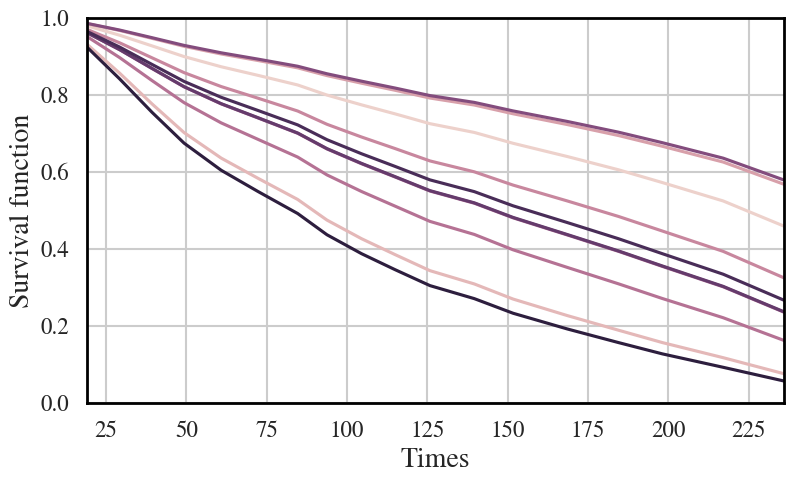

In [7]:
from src import prediction
# select first 10 observations to be explained
explained_data = feats[:10]
# Survival prediction
surv_pred = prediction.predict(model_explainer, explained_data)
prediction.plot_prediction(surv_pred, "survival")

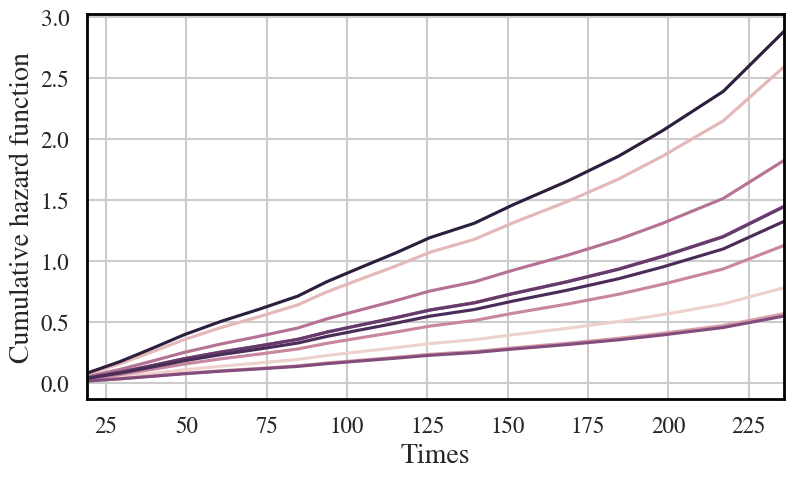

In [8]:
# Cumulative hazard prediction
chf_pred = prediction.predict(model_explainer, explained_data, type="chf")
prediction.plot_prediction(chf_pred, "chf")

### Performance

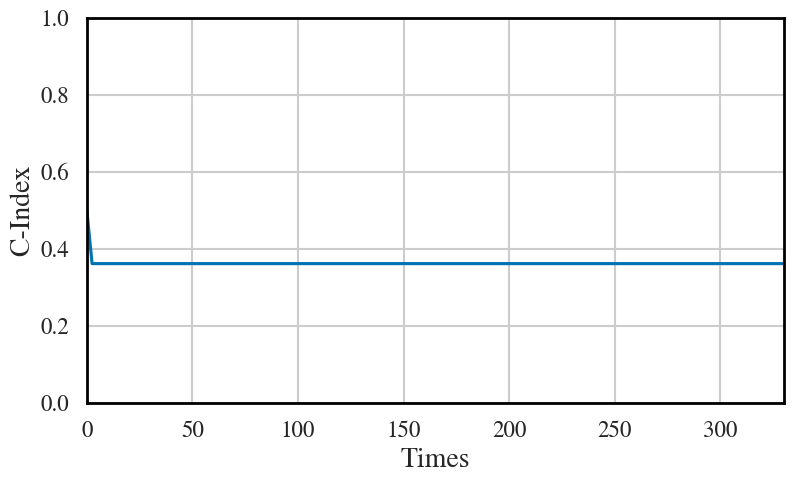

In [9]:
from src import performance
eval_times = np.unique(surv_label[:, 0])[::10]

# C-Index evaluation
cindex_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="c_index")
performance.plot_performance(cindex_perf, metric="c_index")

In [10]:
print(cindex_perf.head(20))

        times      perf
0    0.000000  0.500000
1    2.500000  0.360849
2    5.500000  0.360851
3    9.600000  0.360851
4   11.700000  0.360851
5   14.166667  0.360851
6   15.366667  0.360851
7   16.600000  0.360851
8   18.233334  0.360851
9   19.566668  0.360851
10  20.666666  0.360851
11  21.933332  0.360851
12  23.366667  0.360851
13  24.333334  0.360851
14  25.466667  0.360851
15  27.200001  0.360851
16  28.566668  0.360851
17  29.666666  0.360851
18  30.866667  0.360851
19  31.799999  0.360851


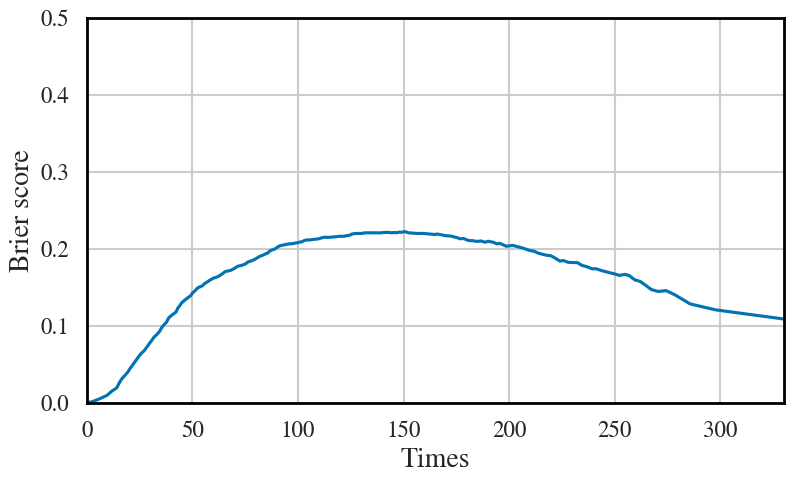

In [11]:
# Brier score evaluation
bs_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="brier_score")
performance.plot_performance(bs_perf, metric="brier_score")

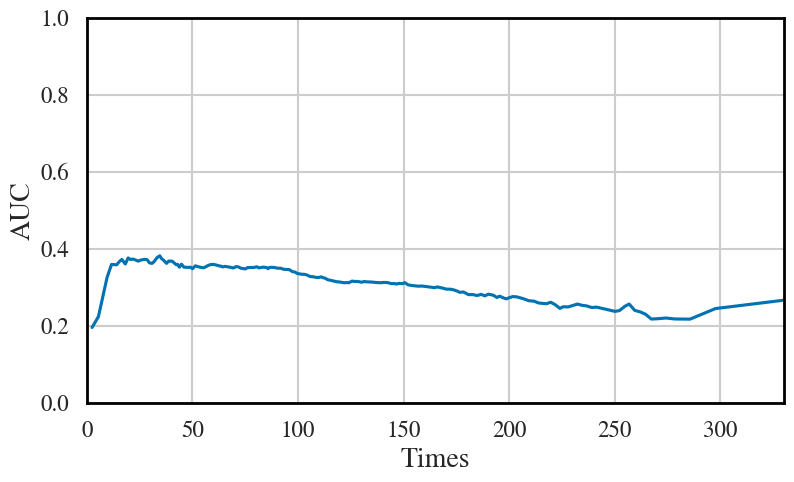

In [12]:
# AUC evaluation
auc_perf = performance.evaluate(model_explainer, feats, surv_label, times=eval_times, metric="auc")
performance.plot_performance(auc_perf, metric="auc")

### Local explaination

In [13]:
from src import local_explaination

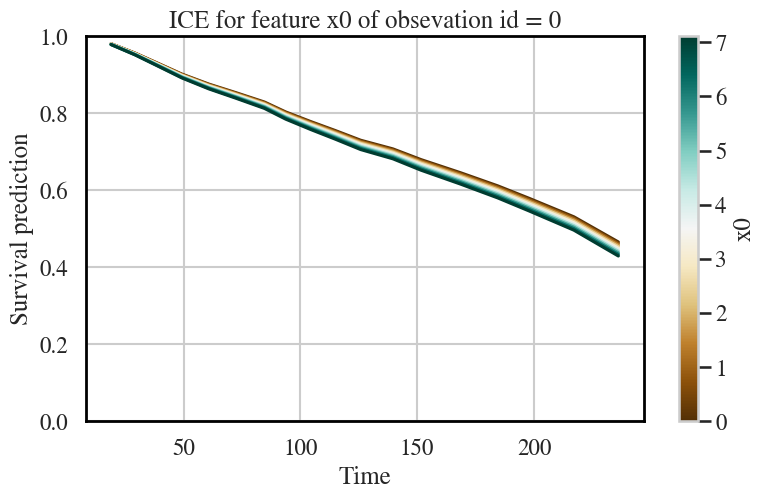

In [14]:
# individual conditional expectation
explained_feature = "x0"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature)

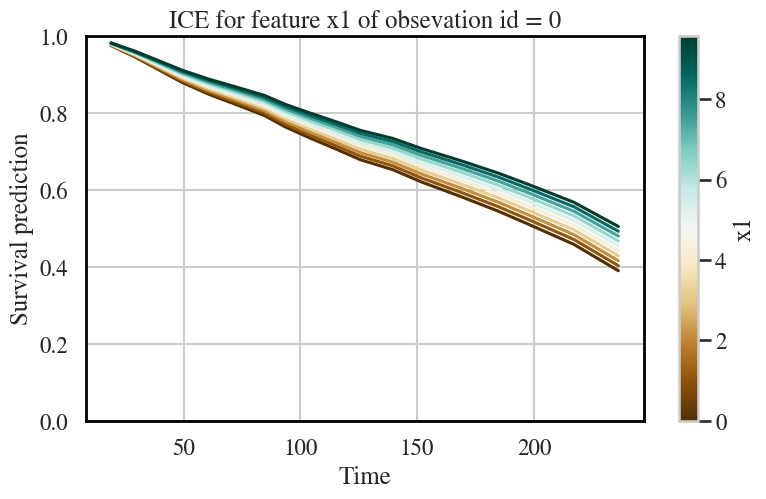

In [15]:
# individual conditional expectation
explained_feature = "x1"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature)

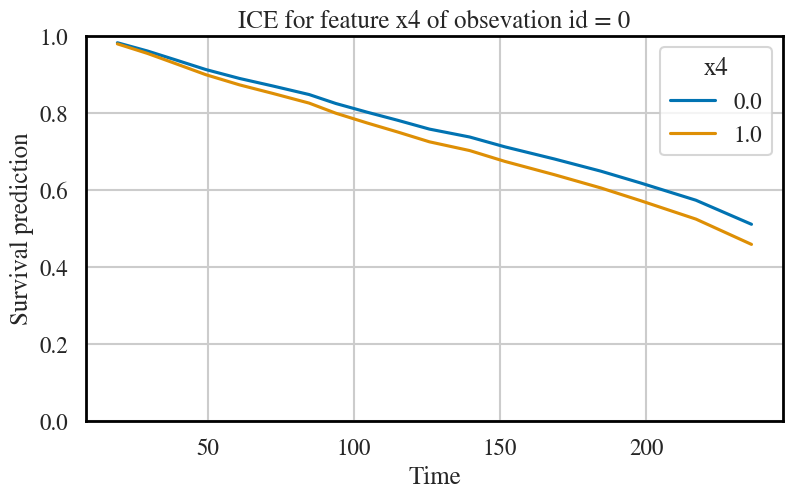

In [16]:
# individual conditional expectation
explained_feature = "x4"
ICE_df = local_explaination.individual_conditional_expectation(model_explainer, 
                                                               explained_feature, 
                                                               n_sel_samples=10, 
                                                               n_grid_points=10)
local_explaination.plot_ICE(model_explainer, ICE_df, explained_feature)

### Global explaination

In [19]:
from src import global_explaination

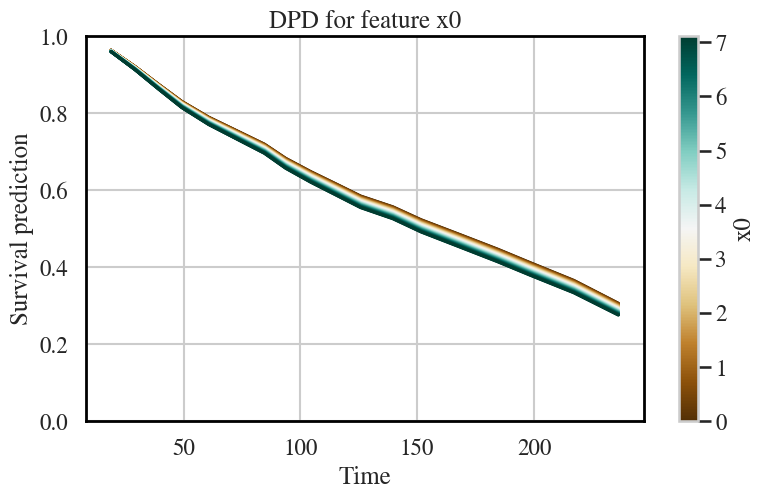

In [20]:
# partial dependence plot
explained_feature = "x0"
PDP_df = global_explaination.partial_dependence_plots(model_explainer, explained_feature, n_sel_samples=10)
global_explaination.plot_PDP(model_explainer, PDP_df, explained_feature)

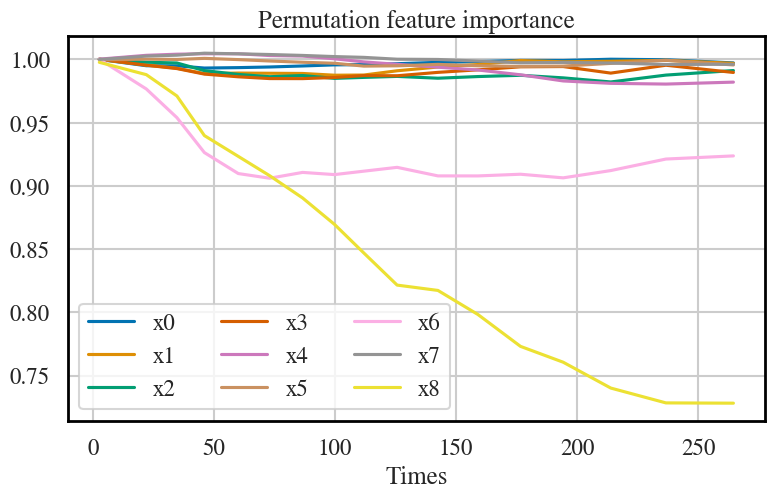

In [21]:
# permuatation feature importance
eval_times = np.unique(surv_label[:, 0])[10::100]
feat_importance_df = global_explaination.permutation_feature_importance(model_explainer, feats, 
                                                                        surv_label, eval_times=eval_times)
global_explaination.plot_PFI(feat_importance_df)